<a href="https://colab.research.google.com/github/Arijit-datascience/pytorch_cifar10/blob/main/pytorch_cifar10_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Training Concepts

In [1]:
import torch
import torch.optim as optim

from torchsummary import summary
from torch.optim.lr_scheduler import StepLR, OneCycleLR, ReduceLROnPlateau

import os
import numpy as np

In [2]:
%%capture
!git clone https://github.com/Arijit-datascience/pytorch_cifar10
!pip install albumentations==1.0.0

In [3]:
from pytorch_cifar10 import main as main
from pytorch_cifar10.model import resnet as models
from pytorch_cifar10.utils import utils as utils
from pytorch_cifar10.utils.gradcam import generate_gradcam, plot_gradcam_images

## Data Loader & Albumentations

In [4]:
norm_mean,norm_std = utils.cifar10_mean_std()
train_transform, test_transform = utils.get_transforms(norm_mean,norm_std)

# Extract and transform the data
train_set,test_set = utils.get_datasets(train_transform,test_transform)

# Targets -> ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = train_set.classes

# Dataloader Arguments & Test/Train Dataloaders - Load part of ETL
train_loader,test_loader = utils.get_dataloaders(train_set,test_set)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
(0.492, 0.483, 0.447) (0.247, 0.243, 0.262)
Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


## Model Summary

In [5]:
# Model summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = models.ResNet18("LN").to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
         GroupNorm-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
         GroupNorm-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
         GroupNorm-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
         GroupNorm-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
        GroupNorm-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
        GroupNorm-14          [-1,

## Training & Testing the Model

In [6]:
if __name__=='__main__':
    
    EPOCH = 40
    batch_size = 256
    l1_factor = 0
    l2_factor = 0.0001
    lr_value = 0.001
    mt_val = 0.9
    
    cuda = torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    
    utils.seed_everything(1)
    
    optimizer = optim.Adam(model.parameters(), lr=lr_value, weight_decay=l2_factor)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.2, patience=3,verbose=True,mode='max')
    
    print("------------------------------------------")
    train_loss, test_loss, train_acc, test_acc = main.main(EPOCH, model, device, train_loader, test_loader, optimizer, scheduler, l1_factor)

------------------------------------------

Epoch 1 : 
Train set: Average loss: 1.7906, Accuracy: 21.30

Test set: Average loss: 0.014, Accuracy: 32.64

Epoch 2 : 
Train set: Average loss: 1.5364, Accuracy: 35.08

Test set: Average loss: 0.012, Accuracy: 42.14

Epoch 3 : 
Train set: Average loss: 1.5778, Accuracy: 42.00

Test set: Average loss: 0.011, Accuracy: 49.03

Epoch 4 : 
Train set: Average loss: 1.4795, Accuracy: 46.69

Test set: Average loss: 0.010, Accuracy: 52.45

Epoch 5 : 
Train set: Average loss: 1.3687, Accuracy: 50.53

Test set: Average loss: 0.009, Accuracy: 58.96

Epoch 6 : 
Train set: Average loss: 1.0870, Accuracy: 54.72

Test set: Average loss: 0.008, Accuracy: 61.07

Epoch 7 : 
Train set: Average loss: 1.1392, Accuracy: 58.06

Test set: Average loss: 0.008, Accuracy: 64.51

Epoch 8 : 
Train set: Average loss: 0.8719, Accuracy: 61.01

Test set: Average loss: 0.007, Accuracy: 67.45

Epoch 9 : 
Train set: Average loss: 1.1101, Accuracy: 63.24

Test set: Average loss:

## Accuracy and Loss Plots

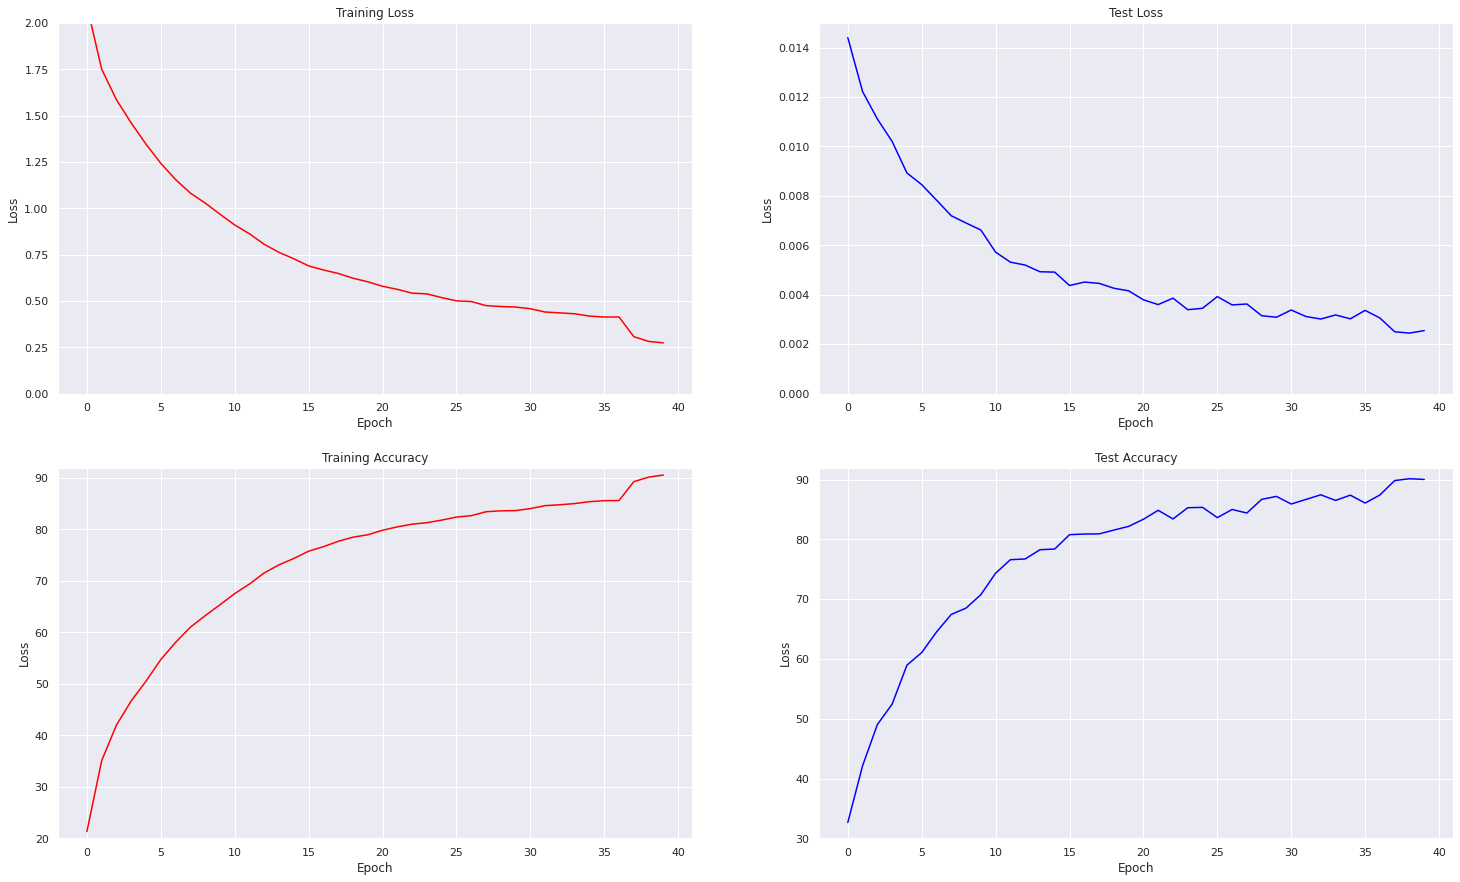

In [30]:
utils.valid_accuracy_loss_plots(train_loss, train_acc, test_loss, test_acc)

## Misclassified images

Total wrong predictions are 997


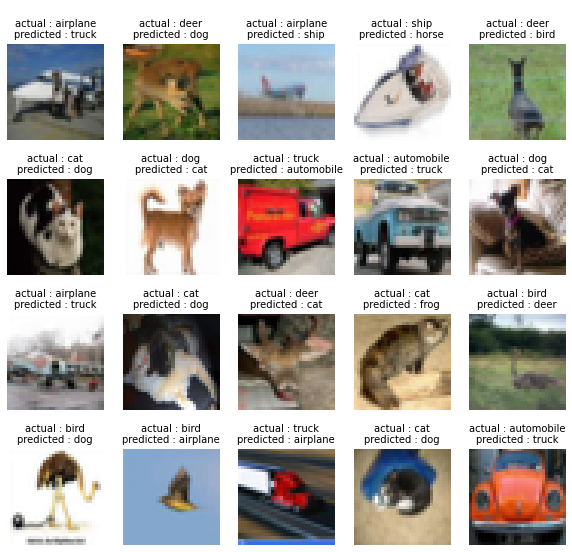

In [22]:
misclassified_images = utils.wrong_predictions(model,test_loader, norm_mean, norm_std, classes)

## GradCAM images for same 20 misclassified images 

In [48]:
%%capture
target_layers = ["layer1","layer2","layer3","layer4"]
gradcam_output, probs, predicted_classes = generate_gradcam(misclassified_images[:20], model, target_layers,device)

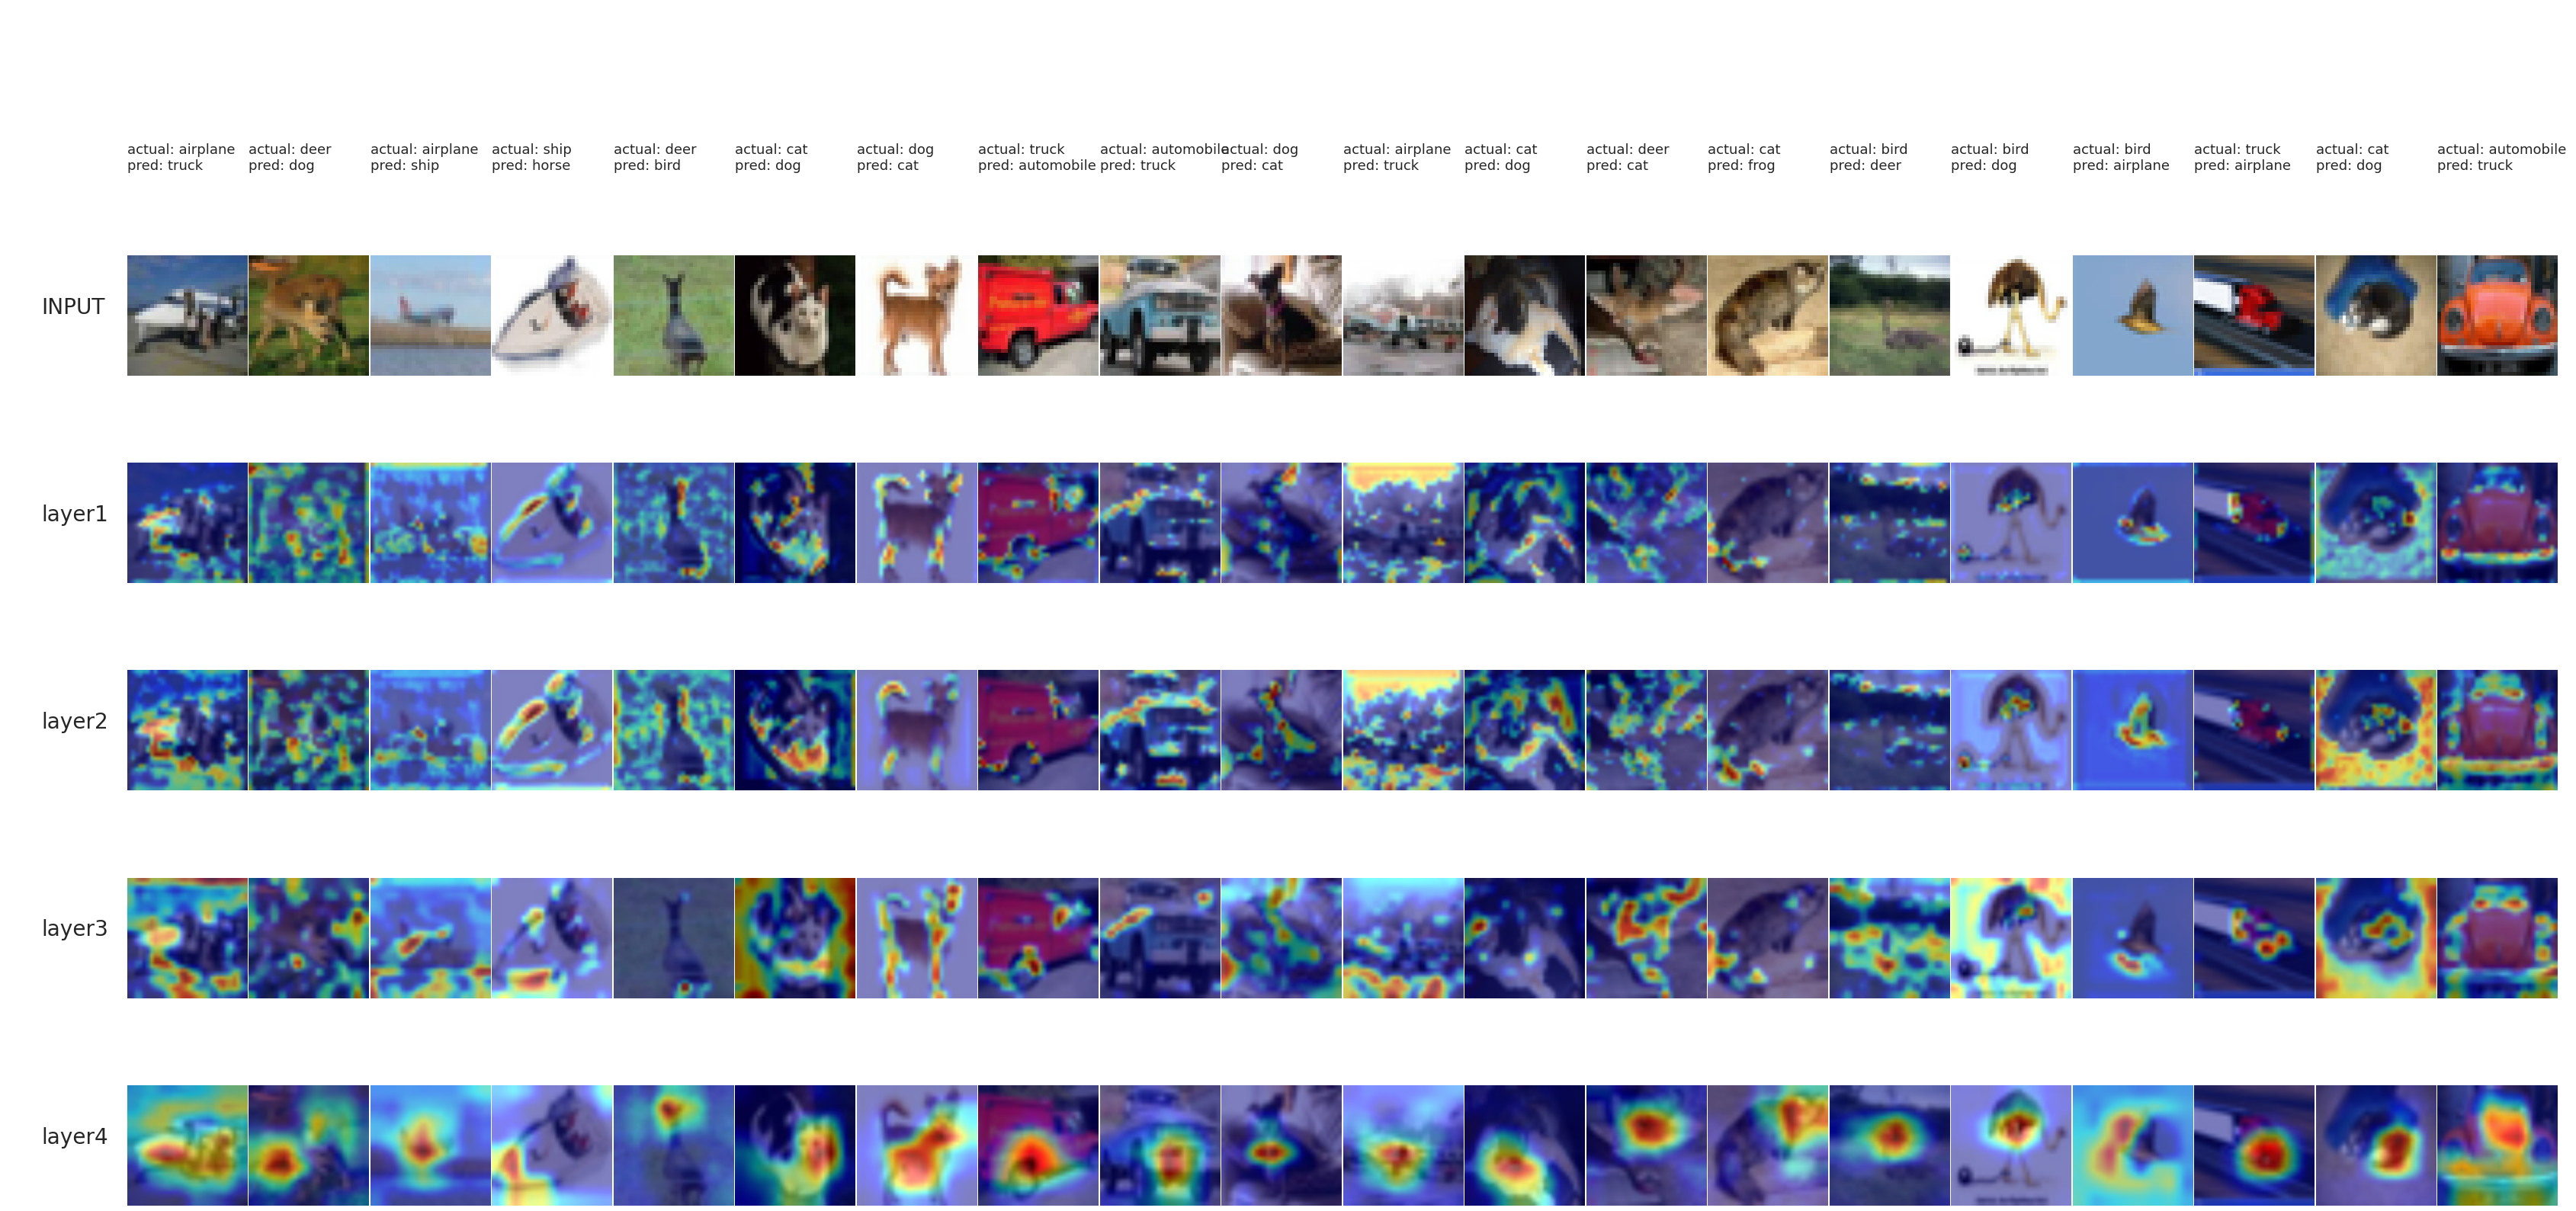

In [49]:
plot_gradcam_images(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, misclassified_images[:20])